### NLP model for Sarcasm Detection

**Problem Statement**<br/>
Develop an NLP classification model for sarcasm detection using the features provided in the
dataset. During the course, explore NLP concepts and models. Further, evaluate and finalize
the best modeling approach for the given dataset.


In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
import pandas as pd
import numpy as np

In [3]:
# read file into pandas using a relative path. Please change the path as needed
st_df = pd.read_csv('NLPMiniProject_data.csv')
st_df.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


In [4]:
#Total number of Comments
st_df.shape

(15000, 10)

In [5]:
st_df[['comment', 'parent_comment', 'label']].groupby('label').count()

,comment,parent_comment
label,,
0,7473,7473
1,7527,7527


In [6]:
st_df.label.value_counts()

1    7527
0    7473
Name: label, dtype: int64

In [7]:
#Check out comment which is legitimate 
msg_num = np.random.randint(0, st_df.shape[0])
print(st_df.loc[msg_num, 'label'], ':', st_df.loc[msg_num, 'comment'])

0 : Holy shit that dude's legs were enormous.


In [8]:
#Checkout missing values
st_df.isnull().sum().sum()

0

### 2. Create Training & Test Dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X= st_df.comment
y = st_df.label

In [11]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3,  random_state=10)

In [12]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [13]:
#Traing and Test datashape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print()

(10500,) (4500,) (10500,) (4500,)



### 3. Tokenization & Vectorization

Using **CountVectorizer**, to get numeric features.

In [14]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
cvect = CountVectorizer()

In [15]:
#Feed Comments data to CountVectorizer
cvect.fit(X_train)

CountVectorizer()

In [16]:
#Check the vocablury size
len(cvect.vocabulary_)

14149

In [17]:
#What is there in the vocabulary
# cvect.vocabulary_

In [18]:
# cvect.get_feature_names()

Build Document-term Matrix (DTM)

In [19]:
#Convert Training comments into Count Vectors
X_train_ct = cvect.transform(X_train)

In [20]:
#Size of Document Term Matrix
X_train_ct.shape

(10500, 14149)

In [21]:
X_train[0]

'There is no Russian bias.'

In [22]:
#Let's check the first record
X_train_ct[0]

<1x14149 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [23]:
#What's there in sparse matrix
print(X_train_ct[0:1])

  (0, 1504)	1
  (0, 6640)	1
  (0, 8577)	1
  (0, 10888)	1
  (0, 12646)	1


Convert Test Comments also in numerical features

In [24]:
X_test_ct = cvect.transform(X_test)

In [25]:
X_test_ct.shape

(4500, 14149)

#### Classification report Generation 

In [26]:
def classification_report_csv(report, model_name):
    report_data = []
    
    lines = report.split('\n')
    # print(lines)
    for line in lines[2:]:
        row = {}
        row_data = line.split('      ')
        # print(row_data, len(row_data))
        if len(row_data) == 1:
            # print('LEN', len(row_data))
            continue
        
        if '    accuracy' in row_data:
            # print('accuracy---', row_data[4].split('     ')[0])
            row['Model'] = model_name
            row['accuracy'] = row_data[4].split('     ')[0]
            row['class'] = ''
            row['precision'] = ''
            row['recall'] = ''
            row['f1_score'] = ''
            row['support'] = ''
            report_data.insert(0, row)
            continue
            
        if '   macro avg' in row_data or 'weighted avg' in row_data:
            row['Model'] = ''
            row['accuracy'] = ''
            row['class'] = row_data[0]
            row['precision'] = row_data[1]
            row['recall'] = (row_data[2])
            # print(row_data[3].split('     '))
            if '     ' in row_data[3]:
                inner_row = row_data[3].split('     ')      
                row['f1_score'] = inner_row[0]
                row['support'] = inner_row[1]
            else:
                row['f1_score'] = (row_data[3])
                row['support'] = (row_data[4])
                
            report_data.append(row)
            continue
        row['Model'] = ''
        row['accuracy'] = ''
        row['class'] = row_data[1]
        row['precision'] = row_data[2]
        row['recall'] = (row_data[3])
        row['f1_score'] = (row_data[4])
        row['support'] = (row_data[5])
        report_data.append(row)
        
    dataframe = pd.DataFrame.from_dict(report_data)
    # print(dataframe.head())
    return dataframe
    # dataframe.to_csv('classification_report.csv', index = False)

### 4. Building an Comments Classifier

Let's first try K-Nearest Neigbour algorithm

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# fit the model with data (occurs in-place)
knn.fit(X_train_ct, y_train)

KNeighborsClassifier()

Evaluation on Test Dataset

In [29]:
from sklearn import metrics

In [30]:
y_pred_knn = knn.predict(X_train_ct)

In [31]:
#Calculate accuracy on Training Dataset
metrics.accuracy_score(y_train, y_pred_knn)

0.6477142857142857

In [32]:
#Calculate accuracy on Test Dataset
metrics.accuracy_score(y_train, y_pred_knn)

0.6477142857142857

In [33]:
knn_classification_report = metrics.classification_report(y_train, y_pred_knn)
print(knn_classification_report)

              precision    recall  f1-score   support

           0       0.60      0.87      0.71      5243
           1       0.76      0.43      0.55      5257

    accuracy                           0.65     10500
   macro avg       0.68      0.65      0.63     10500
weighted avg       0.68      0.65      0.63     10500



In [34]:
result_df = pd.DataFrame()
result_df = result_df.append(classification_report_csv(knn_classification_report, 'KNN'))

We can build Classifier using other algorithms e.g SVM

In [35]:
from sklearn.svm import SVC

In [36]:
#Train an SVM with default parameters
svc = SVC()
svc.fit(X_train_ct, y_train)

SVC()

In [37]:
y_pred_svc = svc.predict(X_test_ct)

In [38]:
#Calculate accuracy on Test Dataset
metrics.accuracy_score(y_test, y_pred_svc)

0.654

In [39]:
#Confusion Metrics to look for f1_score, recall and precision
svc_classification_report = metrics.classification_report(y_test, y_pred_svc)
print(svc_classification_report)
result_df = result_df.append(classification_report_csv(svc_classification_report, 'SVC'))

              precision    recall  f1-score   support

           0       0.62      0.76      0.69      2230
           1       0.70      0.55      0.61      2270

    accuracy                           0.65      4500
   macro avg       0.66      0.65      0.65      4500
weighted avg       0.66      0.65      0.65      4500



### 5. Using TF-IDF Vectorizer

In [40]:
# import and instantiate TF-IDF Vectorizer (with the default parameters)
from sklearn.feature_extraction.text import TfidfVectorizer
tvect = TfidfVectorizer()

In [41]:
#Feed Comments data to CountVectorizer
tvect.fit(X_train)

#Check the vocablury size
len(tvect.vocabulary_)

14149

In [42]:
#Convert Training Comments  into numerical values
X_train_tfidf = tvect.transform(X_train)

X_train_tfidf.shape

(10500, 14149)

In [43]:
#Check first example
print(X_train_tfidf[0])

  (0, 12646)	0.32126867848815116
  (0, 10888)	0.6268361066580272
  (0, 8577)	0.30802051101982353
  (0, 6640)	0.2145629762655059
  (0, 1504)	0.602452509015821


In [44]:
#Convert Test Comments also to tf-idf vectors
X_test_tfidf = tvect.transform(X_test)

Build an SVM

In [45]:
svc_tf = SVC()
svc_tf.fit(X_train_tfidf, y_train)

SVC()

In [46]:
y_pred_svc_tf = svc_tf.predict(X_test_tfidf)

In [47]:
#Calculate accuracy on Test Dataset
metrics.accuracy_score(y_test, y_pred_svc_tf)

0.6497777777777778

In [48]:
#Confusion Metrics to look for f1_score, recall and precision
svc_tf_classification_report = metrics.classification_report(y_test, y_pred_svc_tf)
print(svc_tf_classification_report)
result_df = result_df.append(classification_report_csv(svc_tf_classification_report, 'TF-IDF'))

              precision    recall  f1-score   support

           0       0.63      0.73      0.67      2230
           1       0.68      0.57      0.62      2270

    accuracy                           0.65      4500
   macro avg       0.65      0.65      0.65      4500
weighted avg       0.65      0.65      0.65      4500



### 6. TF-IDF with ngram

In [49]:
#Use ngrams of length upto 2 words
tvect_ngram = TfidfVectorizer(ngram_range=(1,2)) #Tokens can be made of 1 word or 2 words

In [50]:
#Feed Comments data to CountVectorizer
tvect_ngram.fit(X_train)

#Check the vocablury size
len(tvect_ngram.vocabulary_)

74321

In [51]:
# tvect_ngram.vocabulary_

In [52]:
#Convert Training Comments  into numerical values
X_train_tfidf_ngram = tvect_ngram.transform(X_train)

X_train_tfidf_ngram.shape

(10500, 74321)

In [53]:
svc_tf = SVC()
svc_tf.fit(X_train_tfidf_ngram, y_train)

SVC()

In [54]:
y_pred_svc_ng = svc_tf.predict(tvect_ngram.transform(X_test))

In [55]:
#Calculate accuracy on Test Dataset
metrics.accuracy_score(y_test, y_pred_svc_ng)

0.6564444444444445

In [56]:
#Confusion Metrics to look for f1_score, recall and precision
ngram_classification_report = metrics.classification_report(y_test, y_pred_svc_ng)
print(ngram_classification_report)
result_df = result_df.append(classification_report_csv(ngram_classification_report, 'N-Gram'))

              precision    recall  f1-score   support

           0       0.64      0.72      0.67      2230
           1       0.68      0.60      0.64      2270

    accuracy                           0.66      4500
   macro avg       0.66      0.66      0.66      4500
weighted avg       0.66      0.66      0.66      4500



### 7. Building a Deep Learning Model

In [57]:
import tensorflow as tf

In [58]:
# !pip install tensorflow

We will use CountVectorizer features in this case. This can be replaced by TF-IDF features

In [59]:
#Start building a Keras Sequential Model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [60]:
#Add hidden layers
model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(len(tvect.vocabulary_),)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

#Add Output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [61]:
#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1415000   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,420,101
Trainable params: 1,420,101
Non-trainable params: 0
_________________________________________________________________


In [63]:
X_train_ct.todense()[0]

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [64]:
print(X_train_ct[0])

  (0, 1504)	1
  (0, 6640)	1
  (0, 8577)	1
  (0, 10888)	1
  (0, 12646)	1


In [65]:
model.fit(X_train_ct.todense(), y_train,
           validation_data=(X_test_ct.todense(), y_test), 
           epochs=10, batch_size=32)

Epoch 1/10
329/329 [==============================] - 17s 44ms/step - loss: 0.6695 - accuracy: 0.5844 - val_loss: 0.6324 - val_accuracy: 0.6464
Epoch 2/10
329/329 [==============================] - 10s 31ms/step - loss: 0.5318 - accuracy: 0.7419 - val_loss: 0.6517 - val_accuracy: 0.6433
Epoch 3/10
329/329 [==============================] - 12s 36ms/step - loss: 0.3408 - accuracy: 0.8561 - val_loss: 0.7806 - val_accuracy: 0.6271
Epoch 4/10
329/329 [==============================] - 10s 30ms/step - loss: 0.1945 - accuracy: 0.9250 - val_loss: 0.9655 - val_accuracy: 0.6322
Epoch 5/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1130 - accuracy: 0.9592 - val_loss: 1.1437 - val_accuracy: 0.6238
Epoch 6/10
329/329 [==============================] - 12s 37ms/step - loss: 0.0738 - accuracy: 0.9732 - val_loss: 1.3318 - val_accuracy: 0.6227
Epoch 7/10
329/329 [==============================] - 12s 37ms/step - loss: 0.0589 - accuracy: 0.9787 - val_loss: 1.3899 - val_accuracy: 

### 8. Controlling Vocabulary size

Thus far, we have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

In [66]:
# show default parameters for CountVectorizer (TFIDF will have similar parameters)
cvect

CountVectorizer()

However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- **stop_words:** string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

In [67]:
# remove English stop words
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)
len(vect.get_feature_names_out())

13874

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [68]:
# include 1-grams, 2-grams and 3-grams
vect = CountVectorizer(ngram_range=(1, 3))
vect.fit(X_train)
len(vect.get_feature_names())

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


152930

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [69]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)
vect.fit(X_train)
len(vect.get_feature_names_out())

14149

- **min_df:** int, default=1


> Defines, at a minimum, how many documents a word should appear before it is included in Vocablury


In [70]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)
vect.fit(X_train)
len(vect.get_feature_names_out())

5769

In [71]:
# vect.get_feature_names()

- **max_features**: int or None, default=None


> Maximum size of vocabulary. None means no hard limit.




In [72]:
# only keep terms that appear in at least 2 documents, but maximum vocablury is restricted to 2000 words
vect = CountVectorizer(min_df=2, max_features=2000)
vect.fit(X_train)
len(vect.get_feature_names_out())

2000

**Guidelines for tuning Vectorizer:**

- Use your knowledge of the **problem** and the **text**
- **Experiment**, and let the data tell you the best approach!
- Quiet often, number of features are limited by amount of RAM/Compute available.

### Word Cloud

In [74]:
import matplotlib.pyplot as plt # visualization
from wordcloud import WordCloud

In [ ]:
# !pip install wordcloud

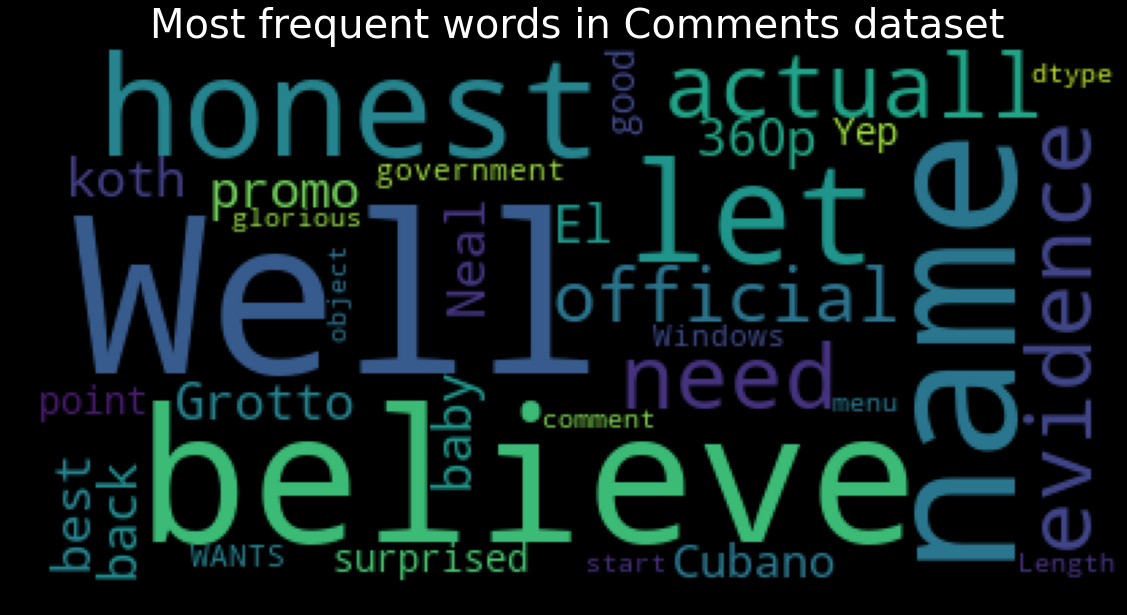

In [75]:
# Define wordcloud function from wordcloud library.
wc = WordCloud()
wc.generate(str(st_df['comment']))
# declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# add title to the graph
plt.title("Most frequent words in Comments dataset", fontsize=40, color='white')
plt.imshow(wc)
plt.show()

In [76]:
result_df

,Model,accuracy,class,precision,recall,f1_score,support
0,KNN,0.65,,,,,
1,,,0,0.60,0.87,0.71,5243
2,,,1,0.76,0.43,0.55,5257
3,,,macro avg,0.68,0.65,0.63,10500
4,,,weighted avg,0.68,0.65,0.63,10500
0,SVC,0.65,,,,,
1,,,0,0.62,0.76,0.69,2230
2,,,1,0.70,0.55,0.61,2270
3,,,macro avg,0.66,0.65,0.65,4500
4,,,weighted avg,0.66,0.65,0.65,4500
